In [3]:
import deepchem as dc

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import LabelEncoder

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [4]:
data = pd.read_csv('../../data/BST.csv',encoding='gb18030')

# 特征提取

In [5]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['SMILES'])
#dataset = dc.data.NumpyDataset(features,data['Label'])

In [6]:
nan_columns = np.isnan(features).any(axis=0)
deleted_columns = np.where(nan_columns)[0]
features_without_nan = features[:, ~nan_columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold

# 初始化VarianceThreshold对象
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# 进行特征选择
X_new = vt.fit_transform(features_without_nan)
dataset = dc.data.NumpyDataset(X_new,data['Label'],ids=data['SMILES'])

# 数据划分

In [8]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset,test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

# Multi-label

In [9]:
train_dataset_y = [ast.literal_eval(label) for label in train_dataset.y]
test_dataset_y  = [ast.literal_eval(label) for label in test_dataset.y]
train_new_y = MultiLabelBinarizer().fit_transform(train_dataset_y)
test_new_y = MultiLabelBinarizer().fit_transform(test_dataset_y)

In [10]:
test_new_y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

# Data distribution ratio

In [11]:
def row_counter(my_array):
    list_of_tups = [tuple(ele) for ele in my_array]
    return Counter(list_of_tups)

In [12]:
print('train_dataset:',row_counter(train_new_y))
train_counter = row_counter(train_new_y)
print('Bitter : Sweet : Tasteless = ',train_counter[(1, 0, 0)]/10420,':',train_counter[(0, 1, 0)]/10420,':',train_counter[(0, 0, 1)]/10420)
print('test_dataset:',row_counter(test_new_y))
test_counter = row_counter(test_new_y)
print('Bitter : Sweet : Tasteless = ',test_counter[(1, 0, 0)]/2606,':',test_counter[(0, 1, 0)]/2606,':',test_counter[(0, 0, 1)]/2606)

train_dataset: Counter({(0, 1, 0): 5684, (0, 0, 1): 3510, (1, 0, 0): 1226})
Bitter : Sweet : Tasteless =  0.11765834932821496 : 0.545489443378119 : 0.33685220729366605
test_dataset: Counter({(0, 0, 1): 1471, (1, 0, 0): 720, (0, 1, 0): 415})
Bitter : Sweet : Tasteless =  0.2762854950115119 : 0.15924788948580199 : 0.5644666155026861


# GridSearchCV

In [13]:
scoring = {
     'F1_score': make_scorer(f1_score,average ='macro'),
     'Accuracy': make_scorer(accuracy_score),
     'Recall': make_scorer(recall_score,average = 'macro'),
     'Precision':make_scorer(precision_score,average = 'macro'),
}

param_grid = {'estimator__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
              'estimator__n_estimators':[30,50,100,150,200],
              'estimator__max_depth': [ 5, 6, 7, 8,10,12]
             }

In [14]:
classifier = GradientBoostingClassifier(random_state=42)
ovr = OneVsRestClassifier(classifier)

gs = GridSearchCV(
                    ovr,
                    param_grid,
                    scoring = scoring,
                    cv = KFold(n_splits=5, shuffle=True, random_state=100),
                    n_jobs = -1,
                    refit = 'F1_score',
                    return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_new_y)

In [15]:
val_F1 = gs.best_score_
val_ACC = gs.cv_results_['mean_test_Accuracy'][gs.best_index_]
val_Recall = gs.cv_results_['mean_test_Recall'][gs.best_index_]
val_Precision = gs.cv_results_['mean_test_Precision'][gs.best_index_]

In [16]:
print('Best parameters: ', gs.best_params_)
print('Best score (F1): ', val_F1)
print('Accuracy:',val_ACC)
print('Recall:',val_Recall)
print('Precision:',val_Precision)

Best parameters:  {'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__n_estimators': 200}
Best score (F1):  0.8585820066955459
Accuracy: 0.869481765834933
Recall: 0.8232376594371615
Precision: 0.9007513306838378


In [17]:
model_multi = gs_fit.best_estimator_
model_multi

OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=10,
                                                         n_estimators=200,
                                                         random_state=42))

# Evaluate model

In [18]:
y_test_pred = model_multi.predict(test_dataset.X)
y_test_pred

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 0]])

In [19]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_new_y, axis=1)
y_pred = np.argmax(y_test_pred, axis=1)

In [20]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [21]:
cm = confusion_matrix(y_true, y_pred)

In [22]:
cm

array([[ 547,   21,  152],
       [  72,  307,   36],
       [ 254,   27, 1190]], dtype=int64)

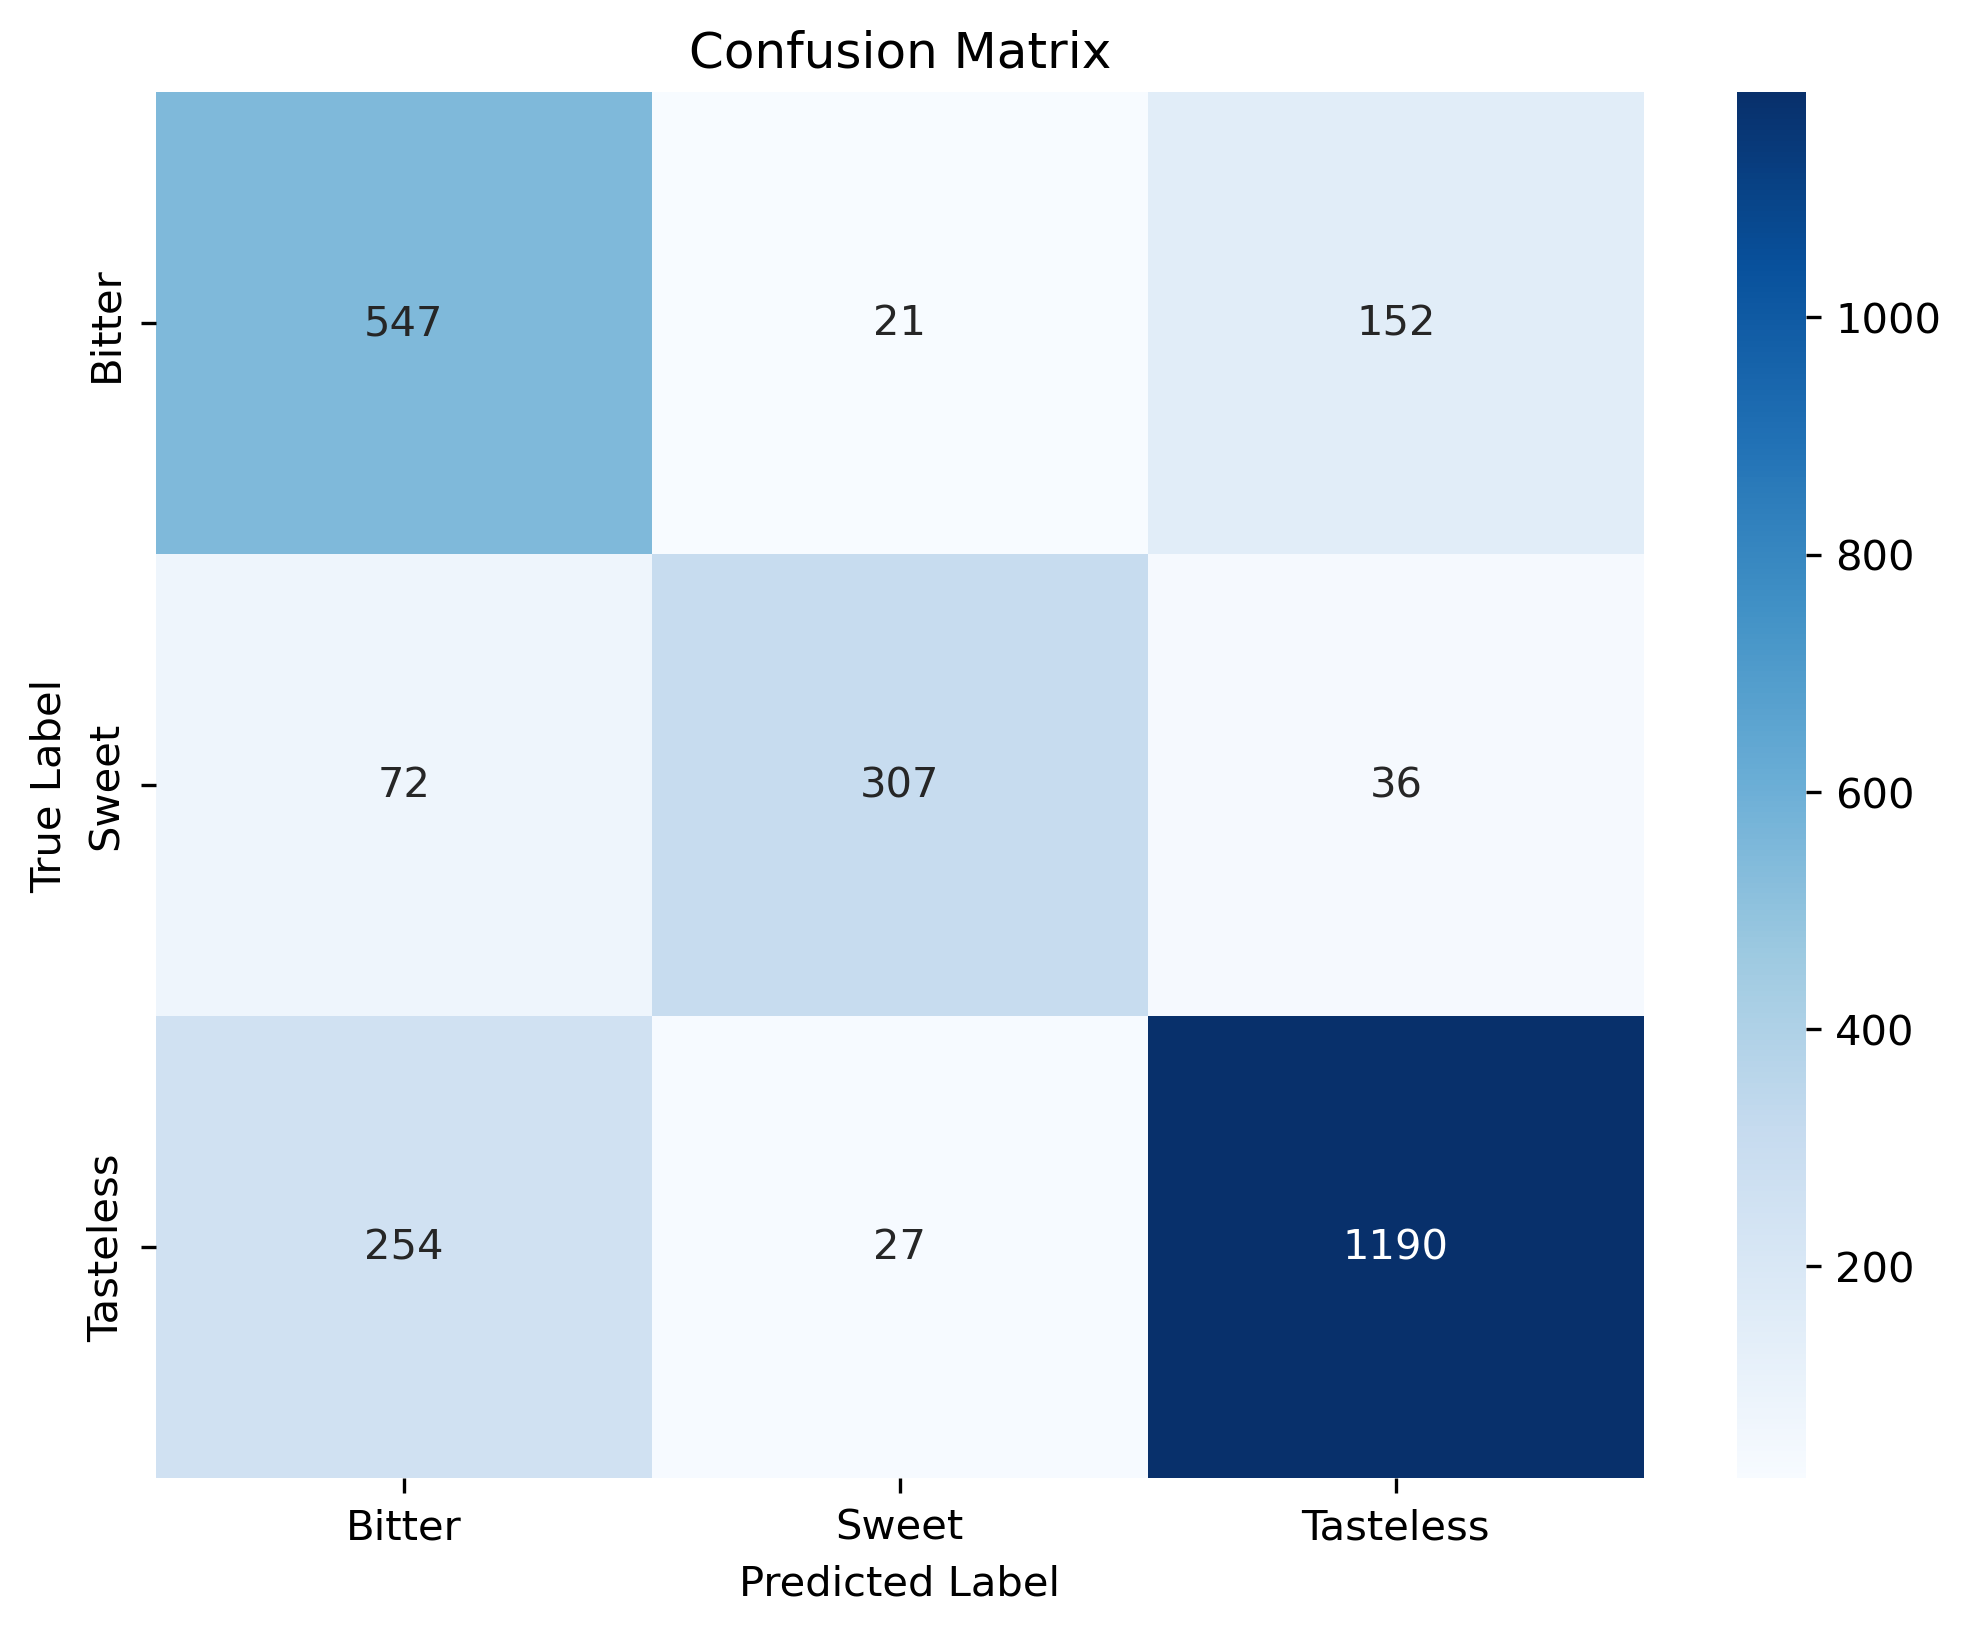

In [23]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 标准化混淆矩阵
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
test_F1 = f1_score(test_new_y, y_test_pred,average ='macro')
test_ACC = accuracy_score(test_new_y, y_test_pred)
test_Recall = recall_score(test_new_y,y_test_pred,average = 'macro')
test_Precision = precision_score(test_new_y, y_test_pred,average = 'macro')

In [25]:
performance_dataset = {
    'F1_score':[val_F1,test_F1],
    'ACC':[val_ACC,test_ACC],
    'Recall':[val_Recall,test_Recall],
    'Precision':[val_Precision,test_Precision],
}

In [26]:
performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
performance

,F1_score,ACC,Recall,Precision
val,0.858582,0.869482,0.823238,0.900751
test,0.746133,0.706830,0.697645,0.808704
